# vgg16 architecture with sgd momentum optimizer and L2 regularization, **data standardized**

In [1]:
import tensorflow as tf
from tensorflow import keras as k
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

tf.keras.utils.set_random_seed(42)  # sets the Python, Numpy, and TensorFlow seed
# tf.config.experimental.enable_op_determinism()

# Data load and splitting

In [2]:
(train_ds, val_ds), info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, as_supervised=True,
                                     split=['train+test[:70%]', 'test[70%:]'], download=True)

# Calculate the number of classes i.e. 37
class_names = info.features['label'].names
NUM_CLASSES = info.features['label'].num_classes

print(f'Number of classes: {NUM_CLASSES}')
print(f'Number of training samples: {len(train_ds)}')
print(f'Number of validation samples: {len(val_ds)}')

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


## visualization

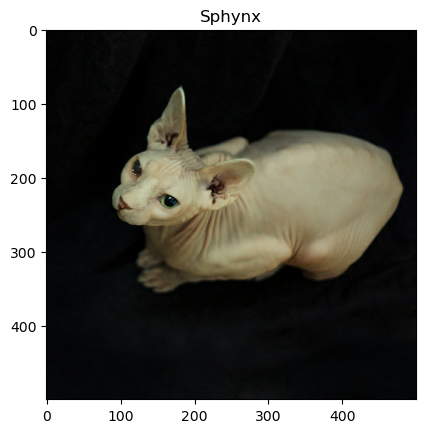

In [3]:
img, label = next(iter(train_ds))
plt.figure()
plt.title(class_names[label])
plt.imshow(img)
plt.show()

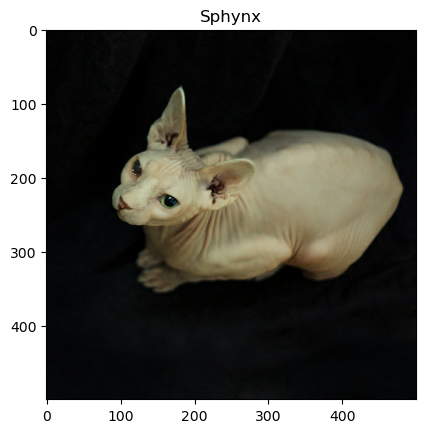

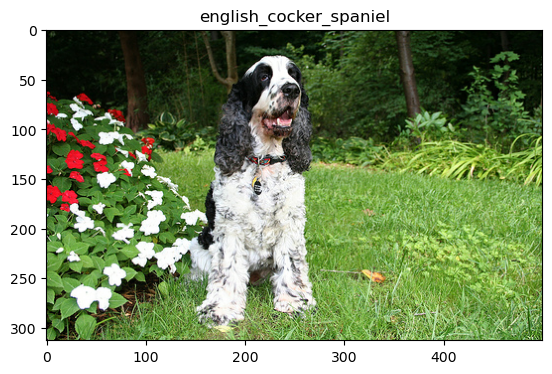

In [4]:
for img,label in train_ds.take(2):
    plt.figure()
    plt.imshow(img)
    plt.title(class_names[label])
    plt.show()

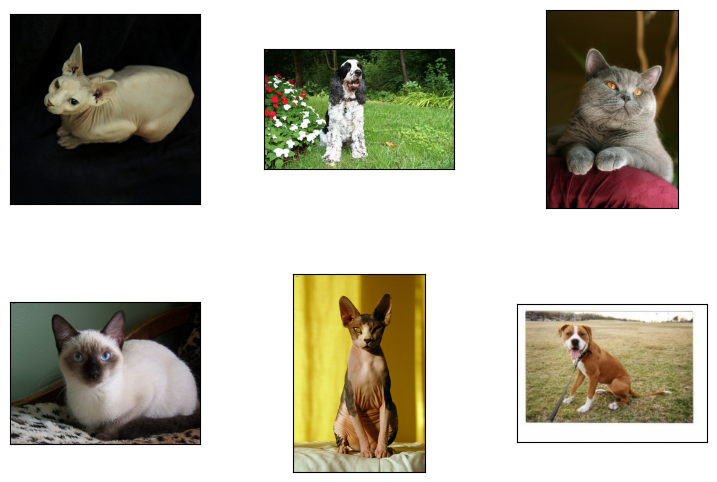

In [5]:
temp = tfds.show_examples(train_ds, info, rows=2, cols=3, image_key='image')

## Histrogram

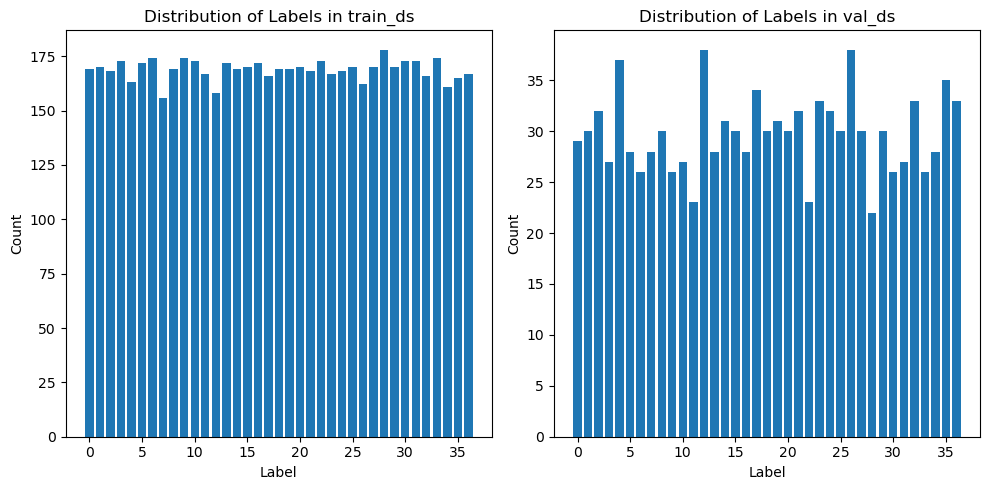

In [6]:
# Get the labels from train_ds and val_ds
train_labels = np.array([label.numpy() for _, label in train_ds])
val_labels = np.array([label.numpy() for _, label in val_ds])

# Count the occurrences of each label in train_ds and val_ds
train_label_counts = np.bincount(train_labels)
val_label_counts = np.bincount(val_labels)

# Plot the histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(train_label_counts)), train_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_ds')

plt.subplot(1, 2, 2)
plt.bar(range(len(val_label_counts)), val_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in val_ds')

plt.tight_layout()
plt.show()

# hyperparamaters

In [7]:
BATCH_SIZE = 128
IMAGE_SIZE = 128

# Data Transformation

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def train_transform(img, label):
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.image.random_hue(img, 0.2, seed=45)
    img = img/255.0
    img = tf.image.random_flip_left_right(img, seed=42)
    return img, tf.one_hot( tf.cast(label, dtype=tf.int32), depth=NUM_CLASSES )

def val_transform(img, label):
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img/255.0
    return img, tf.one_hot( tf.cast(label, dtype=tf.int32), depth=NUM_CLASSES )

train_ds = train_ds.map(train_transform, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(val_transform, num_parallel_calls=AUTOTUNE)


# Standardize Dataset

In [9]:
# # Calculate mean and standard deviation per channel of the training dataset
# def calculate_mean_std_per_channel(dataset):
#     mean = tf.zeros((3,))
#     std = tf.zeros((3,))
#     count = 0
#     for img, _ in dataset:
#         # img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
#         mean += tf.reduce_mean(img, axis=[0, 1])
#         std += tf.reduce_mean(tf.square(img), axis=[0, 1])
#         count += 1
#     mean /= count
#     std = tf.sqrt(std / count - tf.square(mean))
#     return mean, std

# mean, std = calculate_mean_std_per_channel(train_ds)
# print(f"Mean: {mean.numpy()}, Std: {std.numpy()}")
# Mean: [0.46831933 0.44542456 0.40085667], Std: [0.26631337 0.26779917 0.26838252]
mean = tf.constant([0.46831933, 0.44542456, 0.40085667])
std = tf.constant([0.26631337, 0.26779917, 0.26838252])

# Standardize the images in the training dataset per channel
def standardize_image_per_channel(img, label):
    # img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    img = (img - mean) / std
    return img, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(standardize_image_per_channel, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image_per_channel, num_parallel_calls=AUTOTUNE)

# Dataloader

In [10]:
train_ds = train_ds.cache().shuffle(buffer_size=6248*1,seed=42).batch(BATCH_SIZE, deterministic=True, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE, deterministic=True, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

# VGG16 Model

In [11]:
def block(filters, num_conv_layers, l2_reg=None):
    block = k.Sequential()
    for _ in range(num_conv_layers):
        block.add(k.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                                  kernel_initializer=k.initializers.HeUniform(), bias_initializer=k.initializers.Constant(value=0.1),
                                  kernel_regularizer=l2_reg))
    block.add(k.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    return block

def vgg16_make(input_shape, NUM_CLASSES : int =37) -> k.Model:
    l2_reg = k.regularizers.l2(0.005)  # L2 regularization factor
    k.utils.set_random_seed(42)
    vgg16net = k.Sequential([
        k.layers.Input(shape=input_shape),
        # Block 1
        block(filters=64, num_conv_layers=2, l2_reg=l2_reg),
        # Block 2
        block(filters=128, num_conv_layers=2, l2_reg=l2_reg),
        # Block 3
        block(filters=256, num_conv_layers=3, l2_reg=l2_reg),
        # Block 4
        block(filters=512, num_conv_layers=3, l2_reg=l2_reg),
        # Block 5
        block(filters=512, num_conv_layers=3, l2_reg=l2_reg),

        k.layers.Flatten(),
        k.layers.Dense(units=4096, activation='relu', kernel_initializer="he_uniform", bias_initializer=k.initializers.Constant(value=0.1),
                       kernel_regularizer=l2_reg),

        k.layers.Dense(units=4096, activation='relu', kernel_initializer="he_uniform", bias_initializer=k.initializers.Constant(value=0.1),
                       kernel_regularizer=l2_reg),
    ])
    vgg16net.add(k.layers.Dense(units=NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform",
                               bias_initializer=k.initializers.Constant(value=0.1)))
    return vgg16net

In [12]:
model = vgg16_make((IMAGE_SIZE, IMAGE_SIZE, 3), NUM_CLASSES)

In [13]:
model.summary(expand_nested=True)#, show_trainable=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 64)        38720     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d (Conv2D)           (None, 128, 128, 64)      1792      |
|                                                               |
| conv2d_1 (Conv2D)         (None, 128, 128, 64)      36928     |
|                                                               |
| max_pooling2d (MaxPooling2D  (None, 64, 64, 64)     0         |
| )                                                             |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sequential_1 (Sequential)   (None, 32, 32, 128)       221440    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_2 (Conv2D)         (None, 64, 64, 128)       73856     |
|                                                     

In [14]:
# tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_activations=True, expand_nested=True)

# Train and evaluate

In [ ]:
model.compile(
        optimizer=k.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = model.fit(train_ds, epochs=7, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/7
49/49 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - categorical_accuracy: 0.0295 - loss: 128.4625 - val_categorical_accuracy: 0.0436 - val_loss: 127.5842
Epoch 2/7
49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 686ms/step - categorical_accuracy: 0.0629 - loss: 127.5110 - val_categorical_accuracy: 0.0672 - val_loss: 127.3947
Epoch 3/7
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 655ms/step - categorical_accuracy: 0.0935 - loss: 127.2701 - val_categorical_accuracy: 0.0908 - val_loss: 127.1941
Epoch 4/7
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 654ms/step - categorical_accuracy: 0.1180 - loss: 127.0440 - val_categorical_accuracy: 0.0990 - val_loss: 126.9832
Epoch 5/7
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 658ms/step - categorical_accuracy: 0.1414 - loss: 126.8128 - val_categorical_accuracy: 0.1063 - val_loss: 126.8395
Epoch 6/7
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 654ms/step - categorical_accuracy: 0.1609 - loss: 126.6141 - val_categorical_accuracy: 0.1199 - val_loss: 126.6664
Epoch 7/7
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - categorical_